# Machine Learning Nanodegree - Capstone Project

### Data Modelling and Optimisation

#### Kenneth Gjaeringen
#### 5th December 2017

#### Load Libraries

In [1]:
# Import libraries necessary for this project
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from scipy import interp
from sklearn.utils import shuffle
from sklearn.calibration import calibration_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import cross_validation, metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import SGDClassifier
#from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline


/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Load Dataset

In [2]:
# Ensure correct data folder is linked before the data file is uploaded.
os.chdir('/Users/kgjaeringen/Documents/Machine Learning/Udacity/01 Course Code/02 Projects/07 Capstone/03 Data')

# Load data
data = pd.read_csv("main_analysis_data_3.csv", header=0)

data.shape

(230628, 54)

#### Split Dataset Into Data and Target

In [3]:
X = data.drop(["Loan_Status"], axis=1)
Y = data.Loan_Status.values

Xnames = X.columns

X = X.as_matrix()

#data no longer required as split into X and Y
#del data

X.shape


(230628, 53)

#### Create Training and Test Datasets

In [4]:
test_size = 0.40

#Random state defined
seed = 7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


#### Load Algorithms For Model Benchmarking

In [5]:
#Spot-Check Algorithms
models = []
models.append(('ADB', AdaBoostClassifier()))
models.append(('BC', BaggingClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('KNN', KNeighborsClassifier()))

#### Run Algorithms and Extract AUC Charts for Model Selection

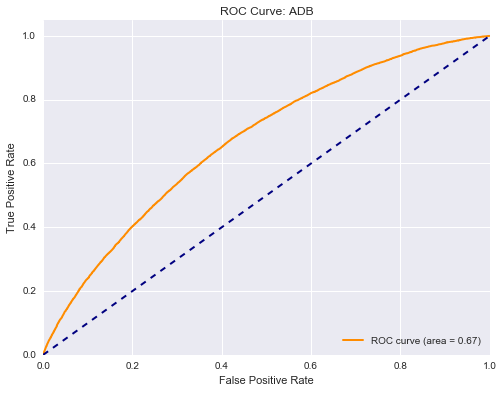

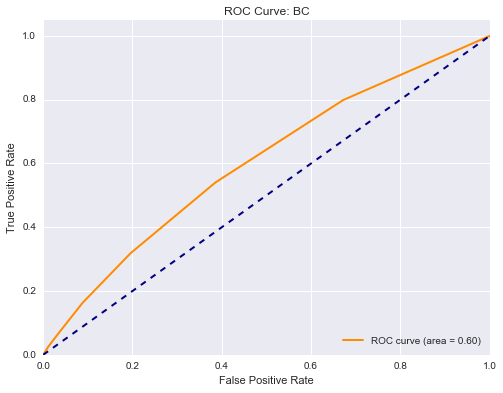

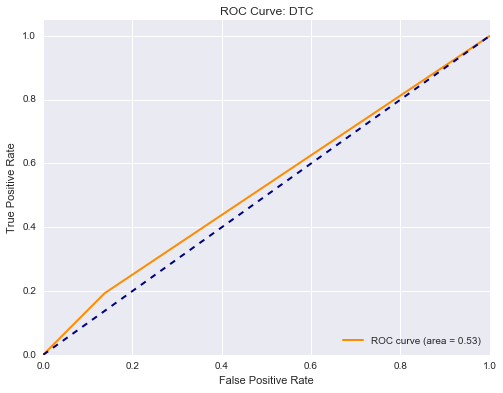

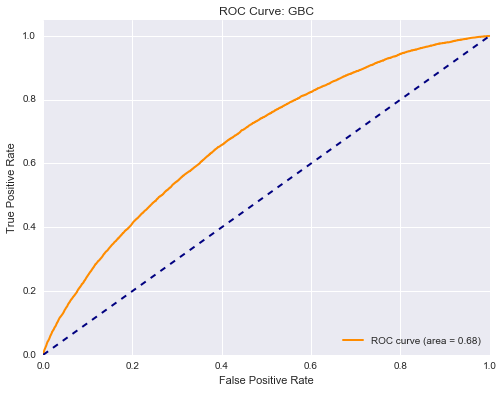

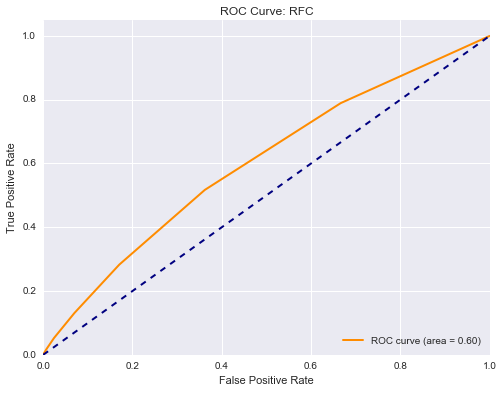

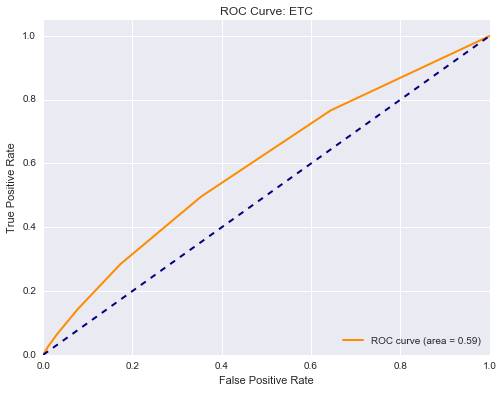

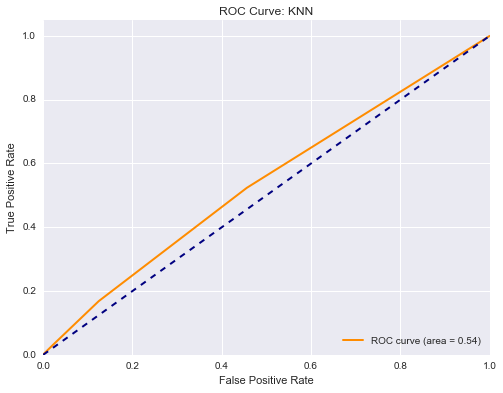

In [6]:
plt.rcParams['figure.figsize'] = (8, 6)

results = []
names = []

num_folds=10

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    clf = model
    clf.fit(X_train, Y_train)
    
    y_predict_probabilities = clf.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(Y_test, y_predict_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: %s' % name)
    plt.legend(loc="lower right")
    plt.show()
    

#### Algorithm Calibration for Model Selection

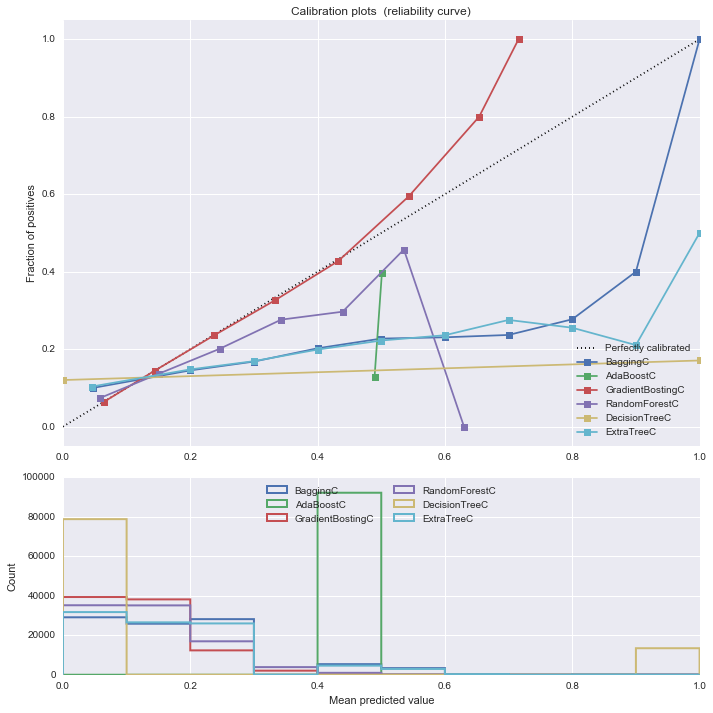

In [7]:
X_train = X_train
X_test = X_test
y_train = Y_train
y_test = Y_test

# Create classifiers
bc = BaggingClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier(n_estimators=100)
dtc = DecisionTreeClassifier()
etc = ExtraTreesClassifier()
#knn = KNeighborsClassifier() takes too long to run and results from the above AUC chart is not good either.

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(bc, 'BaggingC'),
                  (abc, 'AdaBoostC'),
                  (gbc, 'GradientBostingC'),
                  (rfc, 'RandomForestC'),
                 (dtc, 'DecisionTreeC'),
                 (etc, 'ExtraTreeC')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

#Source: http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py


#### Define Function For Modelling and Cross-Validation

This function will do the following:
1. Fit the model selected
2. Determine training F1 score
3. Determine training AUC
4. Determine testing AUC
5. Perform Cross_Validation
6. Plot Feature Importance

Based on source: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [8]:
plt.rcParams['figure.figsize'] = 12, 4

def modelfit(clf, xtrain, ytrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    clf.fit(xtrain, ytrain)
        
    #Predict training set:
    dtrain_predictions = clf.predict(xtrain)
    dtrain_predprob = clf.predict_proba(xtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(clf, xtrain, ytrain, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "F1 Score : %.4g" % metrics.f1_score(ytrain, dtrain_predictions, average='weighted')
    print "AUC Score (Train): %f" % metrics.roc_auc_score(ytrain, dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
#    print(clf.feature_importances_)
#    print(predictors)
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        

#### Baseline Model

The GradientBoostingClassifier returned the highest AUC value nd will the carried forward for further optimisation.


Model Report
F1 Score : 0.8135
AUC Score (Train): 0.696209
CV Score : Mean - 0.686244 | Std - 0.001711229 | Min - 0.6838335 | Max - 0.6885803


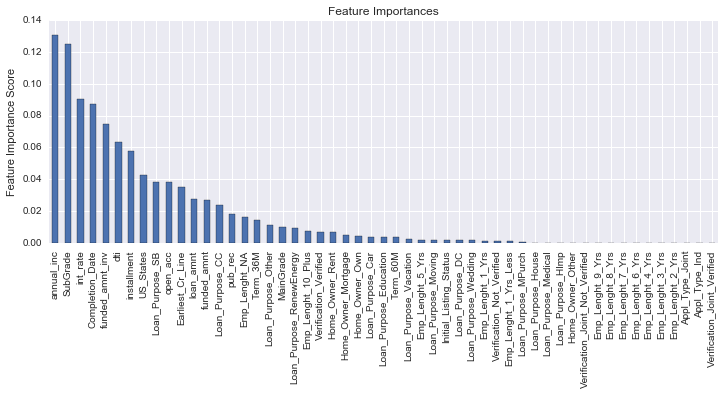

In [9]:

gbc0 = GradientBoostingClassifier(random_state=seed)
modelfit(gbc0, X_train, Y_train, Xnames)


### GBC Models:
There are 2 types of paramters here:
1. Tree-specific parameters
    - min_samples_split
    - min_samples_leaf
    - max_depth
    - max_features
    
2. Boosting specific parameters
    - n_estimators
    - learning_rate
    - subsamples
    

#### Step 1 - Find the number of estimators for a high learning rate

The following benchmarks will be used:
1. min_samples_split = 2000: 0.5% - 1% of total values. Since this dataset has an imbalanced class problem a small value is selected.
2. min_samples_leaf = 50: To prevent overfitting. Optimised later.
3. max_depth = 8: Since high number of observations and predictors a high value is chosen.
4. max_features = 'sqrt': A general rule of thumb as a start value.
5. subsample = 0.8: Typically used value and optimised later.

(0.1 is considered to be a good learning rate to start with. This will be optimised later.)

In [10]:
param_test0 = {'n_estimators':range(20,81,10)}
gsearch0 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                               min_samples_split = 2000,
                                                               min_samples_leaf = 50, 
                                                               max_depth = 8, 
                                                               max_features = 'sqrt', 
                                                               subsample = 0.8, 
                                                               random_state = seed), 
                        param_grid = param_test0, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, 
                        cv=5)

gsearch0.fit(X_train,Y_train)



GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2000,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68371, std: 0.00265, params: {'n_estimators': 20},
  mean: 0.68565, std: 0.00284, params: {'n_estimators': 30},
  mean: 0.68681, std: 0.00282, params: {'n_estimators': 40},
  mean: 0.68731, std: 0.00281, params: {'n_estimators': 50},
  mean: 0.68781, std: 0.00270, params: {'n_estimators': 60},
  mean: 0.68812, std: 0.00265, params: {'n_estimators': 70},
  mean: 0.68835, std: 0.00275, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.68834932924859404)

In [12]:
param_test1 = {'n_estimators':range(60,121,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                               min_samples_split = 2000,
                                                               min_samples_leaf = 50, 
                                                               max_depth = 8, 
                                                               max_features = 'sqrt', 
                                                               subsample = 0.8, 
                                                               random_state = seed), 
                        param_grid = param_test1, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, 
                        cv=5)

gsearch1.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2000,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [60, 70, 80, 90, 100, 110, 120]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [13]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68781, std: 0.00270, params: {'n_estimators': 60},
  mean: 0.68812, std: 0.00265, params: {'n_estimators': 70},
  mean: 0.68835, std: 0.00275, params: {'n_estimators': 80},
  mean: 0.68834, std: 0.00284, params: {'n_estimators': 90},
  mean: 0.68842, std: 0.00279, params: {'n_estimators': 100},
  mean: 0.68848, std: 0.00291, params: {'n_estimators': 110},
  mean: 0.68843, std: 0.00272, params: {'n_estimators': 120}],
 {'n_estimators': 110},
 0.68848445287839277)

#### Step 2 - Tune Tree-Specific Parameters

Moving on to tree parameters which will be done in 3 stages as follows:

1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features


In [14]:
#Tuning 1 - Grid search on max_depth and min_samples_split
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(1800,2601,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=110, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=seed), 
                        param_grid = param_test2, 
                        scoring='roc_auc', 
                        n_jobs=4,iid=False, 
                        cv=5)

gsearch2.fit(X_train,Y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=110,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [1800, 2000, 2200, 2400, 2600], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [15]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68746, std: 0.00256, params: {'min_samples_split': 1800, 'max_depth': 5},
  mean: 0.68718, std: 0.00230, params: {'min_samples_split': 2000, 'max_depth': 5},
  mean: 0.68725, std: 0.00265, params: {'min_samples_split': 2200, 'max_depth': 5},
  mean: 0.68723, std: 0.00315, params: {'min_samples_split': 2400, 'max_depth': 5},
  mean: 0.68730, std: 0.00297, params: {'min_samples_split': 2600, 'max_depth': 5},
  mean: 0.68795, std: 0.00343, params: {'min_samples_split': 1800, 'max_depth': 7},
  mean: 0.68796, std: 0.00316, params: {'min_samples_split': 2000, 'max_depth': 7},
  mean: 0.68798, std: 0.00324, params: {'min_samples_split': 2200, 'max_depth': 7},
  mean: 0.68779, std: 0.00300, params: {'min_samples_split': 2400, 'max_depth': 7},
  mean: 0.68841, std: 0.00349, params: {'min_samples_split': 2600, 'max_depth': 7},
  mean: 0.68719, std: 0.00293, params: {'min_samples_split': 1800, 'max_depth': 9},
  mean: 0.68815, std: 0.00358, params: {'min_samples_split': 2000, 'max_dept

In [16]:
#Tuning 2 - Grid search on min_samples_split and min_samples_leaf
param_test3 = {'min_samples_split':range(2600,3201,200), 'min_samples_leaf':range(30,71,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=110, 
                                                               max_depth=9, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=seed), 
                        param_grid = param_test3, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, 
                        cv=5)

gsearch3.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=110,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [2600, 2800, 3000, 3200], 'min_samples_leaf': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [17]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68871, std: 0.00266, params: {'min_samples_split': 2600, 'min_samples_leaf': 30},
  mean: 0.68823, std: 0.00274, params: {'min_samples_split': 2800, 'min_samples_leaf': 30},
  mean: 0.68849, std: 0.00347, params: {'min_samples_split': 3000, 'min_samples_leaf': 30},
  mean: 0.68852, std: 0.00386, params: {'min_samples_split': 3200, 'min_samples_leaf': 30},
  mean: 0.68846, std: 0.00322, params: {'min_samples_split': 2600, 'min_samples_leaf': 40},
  mean: 0.68856, std: 0.00279, params: {'min_samples_split': 2800, 'min_samples_leaf': 40},
  mean: 0.68792, std: 0.00295, params: {'min_samples_split': 3000, 'min_samples_leaf': 40},
  mean: 0.68806, std: 0.00298, params: {'min_samples_split': 3200, 'min_samples_leaf': 40},
  mean: 0.68810, std: 0.00296, params: {'min_samples_split': 2600, 'min_samples_leaf': 50},
  mean: 0.68879, std: 0.00256, params: {'min_samples_split': 2800, 'min_samples_leaf': 50},
  mean: 0.68806, std: 0.00290, params: {'min_samples_split': 3000, 'min_samples_


Model Report
F1 Score : 0.8135
AUC Score (Train): 0.722885
CV Score : Mean - 0.6891309 | Std - 0.003110668 | Min - 0.6852115 | Max - 0.6927422


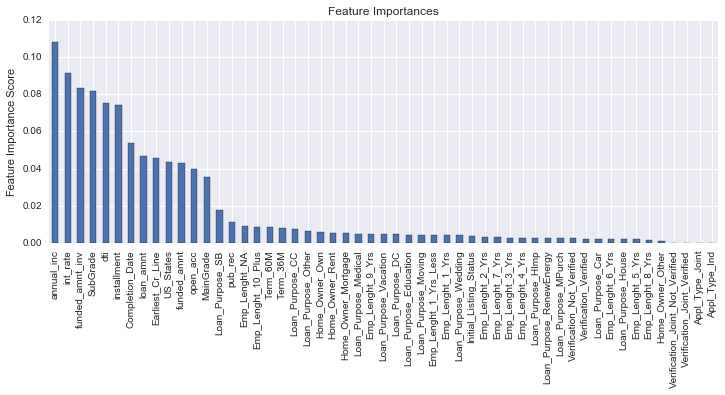

In [18]:
modelfit(gsearch3.best_estimator_, X_train, Y_train, Xnames)

In [19]:
#Tuning 3 - Grid search on max_features
param_test4 = {'max_features':range(7,20,2)}

gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=110, 
                                                               max_depth=9, 
                                                               min_samples_split=3200, 
                                                               min_samples_leaf=50, 
                                                               subsample=0.8, 
                                                               random_state=seed),
                        param_grid = param_test4, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, 
                        cv=5)

gsearch4.fit(X_train, Y_train)



GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=3200,
              min_weight_fraction_leaf=0.0, n_estimators=110,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': [7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [20]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68913, std: 0.00311, params: {'max_features': 7},
  mean: 0.68856, std: 0.00324, params: {'max_features': 9},
  mean: 0.68856, std: 0.00266, params: {'max_features': 11},
  mean: 0.68860, std: 0.00288, params: {'max_features': 13},
  mean: 0.68844, std: 0.00312, params: {'max_features': 15},
  mean: 0.68810, std: 0.00248, params: {'max_features': 17},
  mean: 0.68808, std: 0.00268, params: {'max_features': 19}],
 {'max_features': 7},
 0.68913086655154743)

#### Step 3 - Tune Subsample and Learning Rate

Moving on to boosting parameters which will be done in 2 stages as follows:

1. Tune subsample
2. Tune learning rate

In [21]:
#Grid seach on subsample
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=110, 
                                                               max_depth=9, 
                                                               min_samples_split=3200, 
                                                               min_samples_leaf=50, 
                                                               subsample=0.8, 
                                                               random_state=seed, 
                                                               max_features=7),
                        param_grid = param_test5, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, 
                        cv=5)

gsearch5.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=3200,
              min_weight_fraction_leaf=0.0, n_estimators=110,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/Users/kgjaeringen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68783, std: 0.00321, params: {'subsample': 0.6},
  mean: 0.68791, std: 0.00263, params: {'subsample': 0.7},
  mean: 0.68831, std: 0.00289, params: {'subsample': 0.75},
  mean: 0.68913, std: 0.00311, params: {'subsample': 0.8},
  mean: 0.68825, std: 0.00261, params: {'subsample': 0.85},
  mean: 0.68818, std: 0.00292, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.68913086655154743)

##### Learning rate reduction


Model Report
F1 Score : 0.8127
AUC Score (Train): 0.713407
CV Score : Mean - 0.6882106 | Std - 0.002401509 | Min - 0.6853011 | Max - 0.6908346


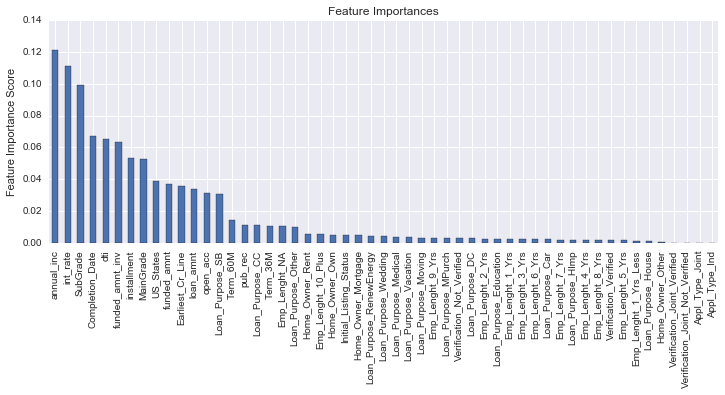

In [23]:

gbc_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, 
                                         n_estimators=110, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7)

modelfit(gbc_tuned_1, X_train, Y_train, Xnames)



Model Report
F1 Score : 0.8129
AUC Score (Train): 0.715691
CV Score : Mean - 0.6897596 | Std - 0.002840271 | Min - 0.6860276 | Max - 0.6929949


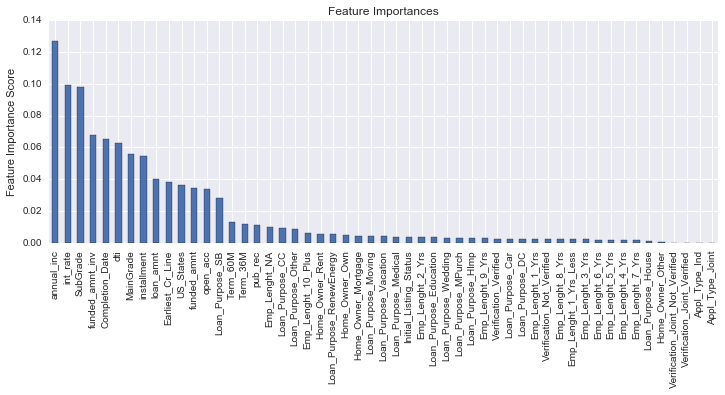

In [24]:
gbc_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, 
                                         n_estimators=600, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7)

modelfit(gbc_tuned_2, X_train, Y_train, Xnames)



Model Report
F1 Score : 0.8128
AUC Score (Train): 0.715595


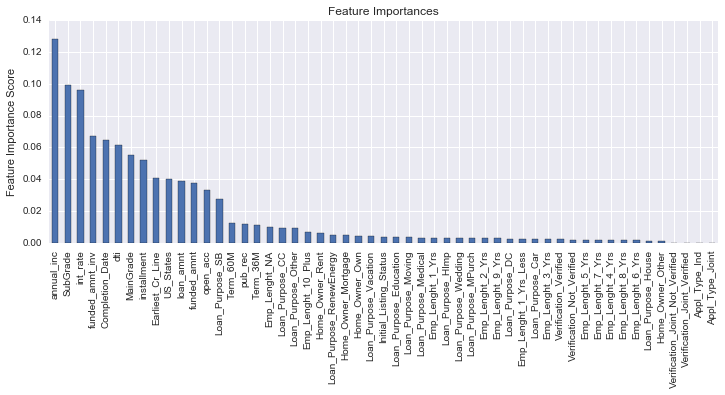

In [25]:
gbc_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, 
                                         n_estimators=1200, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7,
                                         warm_start=True)

modelfit(gbc_tuned_3, X_train, Y_train, Xnames, performCV=False)



Model Report
F1 Score : 0.8131
AUC Score (Train): 0.718640


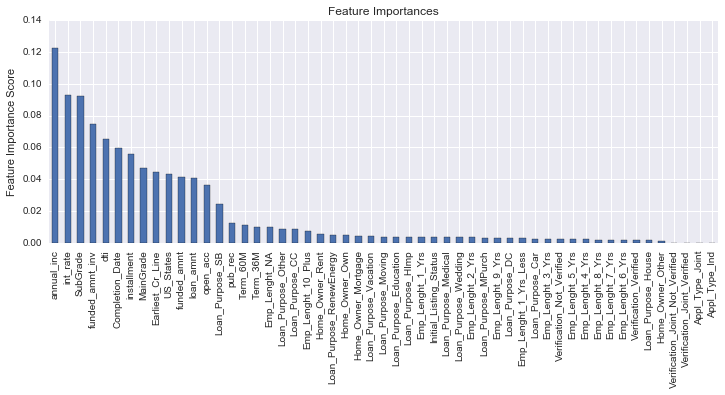

In [26]:
gbc_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, 
                                         n_estimators=1500, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7,
                                         warm_start=True)

modelfit(gbc_tuned_4, X_train, Y_train, Xnames, performCV=False)



Model Report
F1 Score : 0.8136
AUC Score (Train): 0.715030
CV Score : Mean - 0.6788974 | Std - 0.002184295 | Min - 0.676464 | Max - 0.6823052


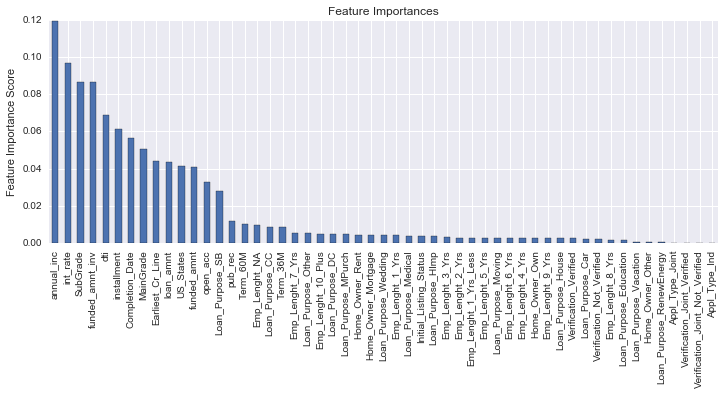

In [27]:
gbc_test = GradientBoostingClassifier(learning_rate=0.005, 
                                         n_estimators=1500, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7)

modelfit(gbc_test, X_test, Y_test, Xnames, performCV=True)


#### Extract the Classification Report to Check Whether the Model is Actually Working Properly

In [28]:
gbc = GradientBoostingClassifier(learning_rate=0.005,
                                 n_estimators=1500, 
                                 max_depth=9, 
                                 min_samples_split=3200, 
                                 min_samples_leaf=50, 
                                 subsample=0.8, 
                                 random_state= seed,
                                 max_features=7)

gbc.fit(X_train, Y_train)

predictions = gbc.predict(X_test)

print(classification_report(Y_test,predictions))


             precision    recall  f1-score   support

          0       0.87      1.00      0.93     80478
          1       0.38      0.00      0.00     11774

avg / total       0.81      0.87      0.81     92252



It is clear from the above Classification Report that although the higher tuned AUC scores it actually isn't predicting any usefull outputs that can be relied upon.

As I have not yet utilised the SMOTE over-sampling function I will do this next.

#### Introduction of SMOTE Over-Sampling Method to Balance the Dataset

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()
X_res, y_res = smote.fit_sample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

#plot_ROC_curve(GBC, X_res, y_res)

X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=test_size, random_state=seed)

Resampled dataset shape Counter({0: 120679, 1: 120679})



Model Report
F1 Score : 0.9234
AUC Score (Train): 0.958210
CV Score : Mean - 0.9521322 | Std - 0.001145379 | Min - 0.9505584 | Max - 0.9535969


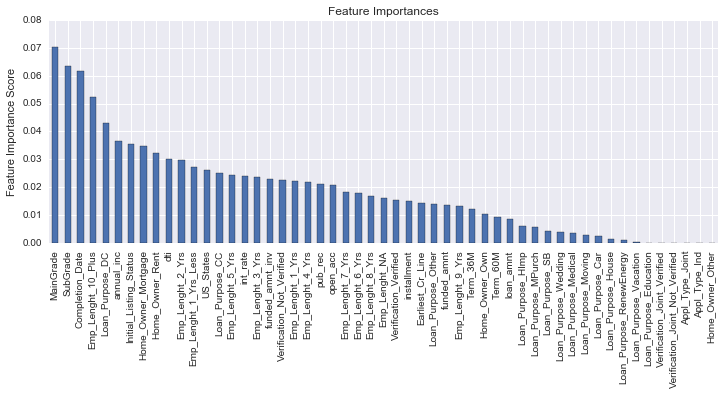

In [33]:
gbc_test2 = GradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=110, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7)

modelfit(gbc_test2, X_test, Y_test, Xnames, performCV=True)

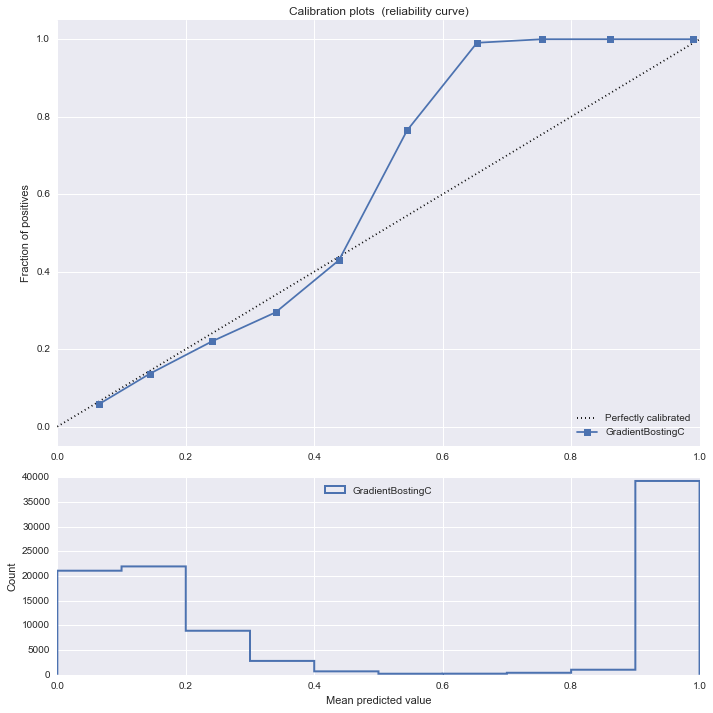

In [34]:

X_train = X_train
X_test = X_test
y_train = Y_train
y_test = Y_test

# Create classifiers
gbc = GradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=110, 
                                         max_depth=9, 
                                         min_samples_split=3200, 
                                         min_samples_leaf=50, 
                                         subsample=0.8, 
                                         random_state=seed, 
                                         max_features=7)

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(gbc, 'GradientBostingC')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

#Source: http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py


In [35]:
predictions = gbc.predict(X_test)
print(classification_report(Y_test,predictions))


             precision    recall  f1-score   support

          0       0.87      1.00      0.93     48164
          1       1.00      0.85      0.92     48380

avg / total       0.93      0.92      0.92     96544



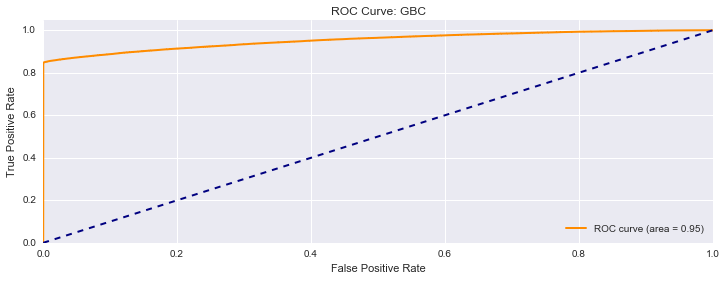

In [36]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
clf = GradientBoostingClassifier(learning_rate=0.1,
                                 n_estimators=110, 
                                 max_depth=9, 
                                 min_samples_split=3200, 
                                 min_samples_leaf=50, 
                                 subsample=0.8, 
                                 random_state= seed,
                                 max_features=7)


clf.fit(X_train, Y_train)
    
y_predict_probabilities = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GBC')
plt.legend(loc="lower right")
plt.show()